# Image processing notebook: From overlap corrected to transmission 

### 00 - Introduction
This notebook demonstrates the use of Jupyter for a Time-of-Flight image processing task. The data corresponds to ToF neutron imaging of coin cells filled with different organic compounds and electrolytes.

*Note: This notebook was written and tested on Windows 10. Running on Mac or Linux machines may need adjustments, e.g. in the path specificationsApplied processing*

### Applied processing
The following processing parts from the averaged pulses, which were already overlap corrected:

- filtering
- Pulse averaging and separtion per experiments
- identification and weighting of OBs for each experiment
- scrubbing correction
- intensity correction
- transmission image generation


### Important Considerations
This notebook starts from the point **after** the overlap correction presented in the image below. This step before (done in a separate notebook) format its destionation directory to be taken by this notebook to process the images correctly.

Transmission Image:

\begin{equation}
T_{img} \rightarrow \frac{I}{I_{0}}=\frac{\frac{\bar{Img}}{OB_{weight}} - SBKG_{img}}{\frac{\bar{Ref}}{OB_{weight}} - SBKG_{ref}}
\end{equation}

## 01 Initial settings
Import all the required libraries

In [1]:
import sys
sys.path.append(r'..\framework')
sys.path.append(r'..\proc_functions')
from stack_proc_func import *
from img_utils_mod import *
import scipy.signal as sp
%matplotlib inline

### Select directories
Select the source directory. This directory is where the images **after** the overlap correction were saved.
Select the destination directory. Here is where the transmission images are going to be saved.

In [2]:
# %load select_directory('src_dir')
src_dir = r"E:\External_Tony\Processed\exp1XX\00_Overlap_corrected"

In [3]:
# %load select_directory('dst_dir')
dst_dir = r"E:\External_Tony\Processed\exp1XX\01_Transmission_results"

### Select working folders
Once the directories are loaded, you can start to do a selection of the folders you want to process. <br>
The next function loads the folders availableas a visual aid. However, you can avoid this step just by looking at the source folder in the windows explorer.

In [4]:
all_folders = prep_stack_dict(src_dir)
for key in all_folders.keys():
    print(key)

00_ob
01_so_ref
02_exp102_00
02_exp102_01
02_exp102_02
02_exp102_03
02_exp102_04
03_ob_end


For this test we will select some folders that we want to process as '`proc_folder`' and our reference as '`ref_folder`'.

* _note: `proc-folder` can take several strings as value, for that reason is a list of strings. On the other hand, `ref_folder` is always one, for that reason it is just a string._

In [5]:
proc_folder_01 = ["02_exp102_00","02_exp102_01"]
proc_folder_02 = ["02_exp102_02","02_exp102_03","02_exp102_04"]

ref_folder = '01_so_ref'

## 02 Filtering process definition
Here we define the process that each image will have before the pulse averaging (if any).

* _note: The sequence generated must contain the names of each function and at the end the 'stack_avg' function which performs the pulse averaging. <br> i.e.  test_seq = [`function_1`, `function_2`, `more functions`, `stack_avg`]_

### White spots filtering
The white spots are removed by applying a median filter of size 'ws_filter_size'

In [6]:
from skimage.filters import gaussian, median, meijering
from skimage.morphology import disk

def ws_filter(src_img, ws_filter_size, **kwargs):
    return sp.medfilt2d(src_img.astype('float32'), ws_filter_size)

def gaussian_filter(x, sigma,**kwargs):
    return gaussian(x, sigma)

def outlier_removal (img, threshold, **kwargs):
    mask_x = np.where(img <= threshold)[0]
    mask_y = np.where(img <= threshold)[1]
    for x, y in zip(mask_x, mask_y) :
        slice = img[max(0, x-1):x+1, max(0,y-1):y+1] # assuming you want 5x5 square
        img[x,y] = np.mean([i for i in slice.flatten() if i > threshold])  # threshold is 0
    return img

def median_filter(x, **kwargs):
    return median(x)
def remove_nan (img, **kwargs):
    return np.nan_to_num(img)

In [7]:
roi_crop = [1, 356, 509, 129]

In [8]:
test_seq = [crop_img, outlier_removal, stack_avg]

## 03 Filter testing
The `test_filter_stack` function test the filters given in the `test_seq` list and prints the image.<br> A selection of a testing folder named `test_folder` is required to proceed with the image checkout. <br> 
-If no specific image is selected, it automatically selects the image at the median point in the stack.<br>

* _note: if the filtering functions inserted in the `test_seq` require aditional arguments or variables, they can be given as `**kwargs` inside the function parameters. i.e `ws_filter_size = 5` was given in the function for the ws_filter usage._

threshold = 0
roi_crop = [1, 356, 509, 129]


Averaging: 100%|███████████████████████████████| 40/40 [00:01<00:00, 30.54it/s]


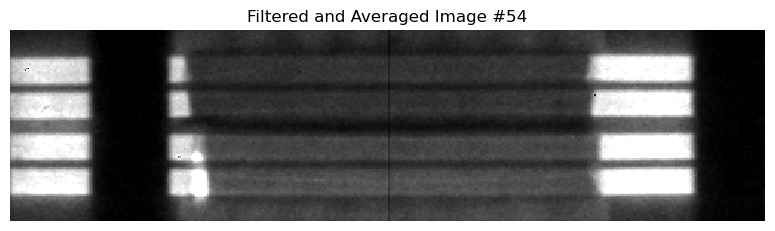

threshold = 0
roi_crop = [1, 356, 509, 129]


Averaging: 100%|███████████████████████████████| 40/40 [00:12<00:00,  3.12it/s]


In [9]:
test_folder = '02_exp102_03'
img = test_filtering_stack (src_dir,dst_dir, test_folder = test_folder, 
                            test_seq = test_seq, give_img=True, threshold = 0, roi_crop = roi_crop)
img_stack = test_filtering_stack (src_dir,dst_dir, test_folder = test_folder, 
                            test_seq = test_seq, give_stack=True, threshold = 0, roi_crop = roi_crop)
img_list = []
for key, value in img_stack.items():
    for imgs in value:
        img_list.append(imgs[0])

### Confirm the operations sequence
After you are satisfied with the result, write the real sequence `seq` that will be used for all the images.

In [10]:
seq = [crop_img, outlier_removal]

## 04 Selecting ROIS and other variables
Each campaign is different, if there are some requirements that the processing require, you can insert them as `**kwargs`. <br>
In the case of this specific campaing (PSI19_03NI), the MCP detector did not adquire correctly the first 9 images in each process. For that reason, the processing needs to remove those images. Thus, we can slice the folder by givin the values that we want with `start_slice` and `end_slice`. 

* _note: If we want to slice the starting but not the end, it is just required to give the beginning (`start_slice`) and leave `end_slice` blank as in the next example._

### ROI selection (program still needs the implementation of the CSV option)
One important parameter are the ROIs, specifically the non-changing-area (nca). Fo that reason, we do a use an interactive command to select them.

If more ROIs were selected (other than the first -nca-), these will be used to create a CSV file at the end with the all the transmission values included. <br>**waiting for implementation in stack_batch_proc**

The window for ROI selection still open in a separate window, I am checking the way to have it printed in the notebook to avoid changing any mistake 

* _note: the option 'flip_image = True' is required to agree with imageJ format of showing the image. In stack_batch_proc it is implemented in the intensity correction part (TFC_corr). The modifications done to img_utils _

**to select several ROIs: for each ROI selected, press ENTER, when finish, press ESC**

In [11]:
# %load select_rois(img, list_rois = ['nca'])
nca = [405, 73, 50, 11]

To agree with the selected ROIs, the image is shown with its labeling, being label 1 the first ROI selected i.e nca, second label 2 and so forth

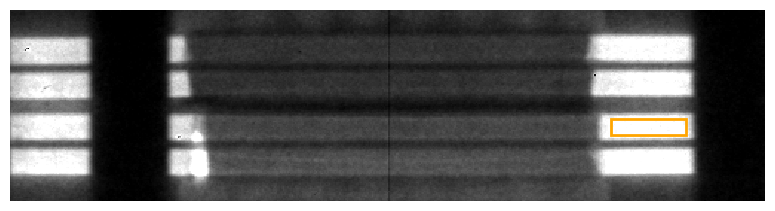

In [12]:
show_img(img, dr = [nca])

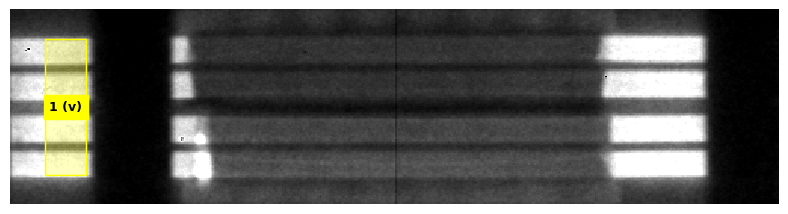

In [36]:
reg_img = get_img(src_dir + '/reg_img_LE.fits')
reg_rois = reg_rois = [([23, 19, 27, 90], 'h'), ([413, 19, 27, 90], 'v')]#, ([313, 17, 84, 16], 'v'), ([108, 94, 48, 15], 'v'),
#([206, 17, 48, 44], 'v'), ([256, 66, 48, 44], 'v')]#, ([23, 19, 27, 90], 'v'), ([413, 70, 27, 39], 'v')]
show_img_rois(img, dr = [(reg_rois, 'yellow')])

In [37]:
img_reg_corr1, res1 = img_registration (img, reg_img[0], num_iter =3, method = '2', rois_list = reg_rois, dof=['ty'])
img_reg_corr2, res2 = img_registration (img, reg_img[0], num_iter =3, method = '3', rois_list = reg_rois, dof=['ty'])

error: (mx>kx) failed for hidden mx: regrid_smth:mx=1

{'tvec': array([-0.07828262,  0.00902895]), 'success': 0.6244839296861645, 'angle': -0.021947477498997614, 'scale': 1.0005231836516684, 'Dscale': 0.002103196327575885, 'Dangle': 0.08840864440078586, 'Dt': 0.25, 'timg': array([[10.98284857, 11.07145548, 11.40960386, ...,  6.34391976,
         6.65896346,  6.05718934],
       [11.44966481, 11.80702337, 11.82811094, ...,  6.60512282,
         6.95251185,  6.40151577],
       [11.58564309, 10.45320054, 11.37083683, ...,  6.59958408,
         6.39162863,  6.48823112],
       ...,
       [12.33038969, 14.25946852, 15.68005007, ...,  6.29543189,
         7.03681653,  7.41244747],
       [13.68125979, 14.33894931, 14.93241799, ...,  6.58101807,
         7.19718595,  7.32612444],
       [13.78633309, 15.08846532, 14.90630324, ...,  6.69562355,
         6.80389607,  7.20464432]])}


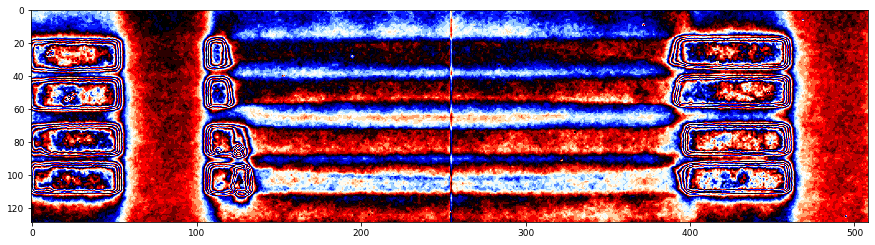

In [38]:
plt.rcParams['figure.figsize'] = [15, 8]
plt.imshow(img_reg_corr1/reg_img[0], cmap = 'flag')
print(res1)

[[ 1.    0.   -0.3 ]
 [ 0.    1.    0.14]
 [ 0.    0.    1.  ]]


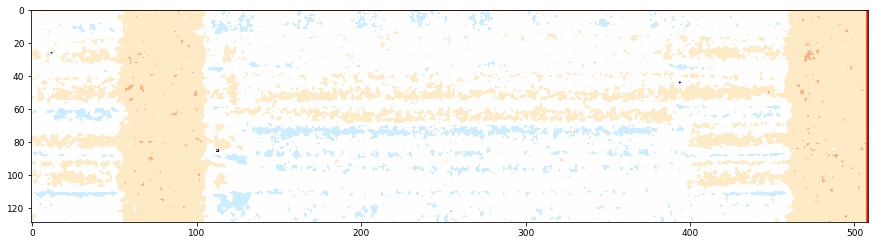

In [27]:
plt.rcParams['figure.figsize'] = [15, 8]
plt.imshow(img_reg_corr2/reg_img[0], cmap = 'flag')
print(res2)

## 05 BB mask
The BB mask is a fits image saved in the source directory. if all the experiments are aligned, one BB mask can be used. However, if there are misalignments, several BB masks must be given. 

**a program that creates the BB mask for that specific experiment would be extremly useful in this case so we do not need to care anymore about BBs**

For the moment being and as an example, the program takes a real (for testing) BB mask to include it in the process

In [17]:
ref_mask_img = get_img(src_dir + '/bb_mask.fits')
img_mask_img = get_img(src_dir + '/bb_mask.fits')

## 06 Run first transmission image test 
This will give you one transmission image as an example of the whole process.

Set a starting and ending slice (to speed up the process, do not choose more tan 10 images or do it in different parts of the spectrum)

In [18]:
stack_test = stack_batch_proc (src_dir, dst_dir, ref_mask_img,img_mask_img, reg_img, proc_folder = [test_folder], 
         ref_folder = ref_folder, avg_seq = seq, save_results = False, start_slice = 30, end_slice = 40, 
         print_TFC = True, nca=nca, threshold = 0, roi_crop =roi_crop, stack_avg=False, scrubbing=True, 
        HE_LE = ([3,18],[68,83]), num_iter = 3, method = '3', rois_list = reg_rois)

start_slice = 30
end_slice = 40
print_TFC = True
nca = [405, 73, 50, 11]
threshold = 0
roi_crop = [1, 356, 509, 129]
stack_avg = False
num_iter = 3
method = 3
rois_list = [([403, 94, 56, 14], 'h'), ([402, 70, 56, 16], 'h'), ([313, 17, 84, 16], 'h'), ([108, 94, 48, 15], 'h'), ([206, 17, 48, 44], 'h'), ([256, 66, 48, 44], 'v')]


Processing: 100%|████████████████████████████████| 6/6 [00:00<00:00, 25.50it/s]


Performing Scrubbing Correction
Performing Image Registration for exp 02_exp102_03 with method 3
01_so_ref
01_so_ref


Processing: 100%|██████████████████████████████| 10/10 [00:00<00:00, 12.51it/s]


02_exp102_03


Processing: 100%|██████████████████████████████| 10/10 [00:00<00:00, 13.01it/s]


ref folder processing: folder_00
area cropped (img) = 0.3952136689456621
area cropped (ref) = 0.36213446248687287
0.9163004494580441
area cropped (img) = 0.3693109969504772
area cropped (ref) = 0.36300788667660905
0.9829327847642908
area cropped (img) = 0.3813220490588828
area cropped (ref) = 0.35615890820117757
0.9340107897778038
area cropped (img) = 0.3929431460077432
area cropped (ref) = 0.35676087778710885
0.9079198388157625
area cropped (img) = 0.3535225673782419
area cropped (ref) = 0.34698698826468827
0.9815129790383055
area cropped (img) = 0.3716033742689867
area cropped (ref) = 0.34408826332491116
0.9259557021025363
area cropped (img) = 0.36268350460006415
area cropped (ref) = 0.3448680573913659
0.9508788048457192
area cropped (img) = 0.3873553847516874
area cropped (ref) = 0.33908406776825883
0.8753823520115186
area cropped (img) = 0.35024186343737707
area cropped (ref) = 0.33330911161643867
0.9516541179436536
area cropped (img) = 0.3631259416000182
area cropped (ref) = 0.330

area cropped (img) = 0.3675133077773254
area cropped (ref) = 0.3304527965312309
0.8991587230671133
ref folder processing: folder_24
area cropped (img) = 0.3277971558385008
area cropped (ref) = 0.36213446248687287
1.1047516918215403
area cropped (img) = 0.3301528459019224
area cropped (ref) = 0.36300788667660905
1.0995146374853506
area cropped (img) = 0.3327835252979446
area cropped (ref) = 0.35615890820117757
1.0702420075702508
area cropped (img) = 0.3594587952729926
area cropped (ref) = 0.35676087778710885
0.9924945013966487
area cropped (img) = 0.338432047200159
area cropped (ref) = 0.34698698826468827
1.0252781648053253
area cropped (img) = 0.3362508783709326
area cropped (ref) = 0.34408826332491116
1.023308147154735
area cropped (img) = 0.3390411217463057
area cropped (ref) = 0.3448680573913659
1.017186515945462
area cropped (img) = 0.318403289066623
area cropped (ref) = 0.33908406776825883
1.0649515234665448
area cropped (img) = 0.3265662784192006
area cropped (ref) = 0.3333091116

### Testing the NCA region 

This region is characterized for having a value of 1. The process might have an error if this region has values greater that 0.05% of the theoretical one.

In [19]:
nca_reg =[]
for key, val in stack_test.items():
    print(key)
    for key2, im in val.items():
        print(key2)
        for arr in im:
            nca_reg.append(np.mean(roi_in_image(arr[0],nca)))
        print('value cropped reg {}'.format(np.mean(nca_reg)))
        print(nca_reg)
print(len(nca_reg))
print('Average value in the NCA is {}'.format(np.mean(nca_reg)))

02_exp102_03
folder_00
value cropped reg 1.0008956733708736
[1.0008315708516264, 1.0001928333248544, 1.0009446878018973, 1.001306408965154, 1.0007393754613993, 1.0011888992064526, 1.0009001424713753, 1.0003883351661105, 1.000971690663698, 1.0014927897961674]
folder_01
value cropped reg 1.0009389152140031
[1.0008315708516264, 1.0001928333248544, 1.0009446878018973, 1.001306408965154, 1.0007393754613993, 1.0011888992064526, 1.0009001424713753, 1.0003883351661105, 1.000971690663698, 1.0014927897961674, 1.0003608279632674, 1.0017056610349726, 1.0007833509880124, 1.0007521671807578, 1.0006559663359829, 1.0015581020361122, 1.001132665701422, 1.001517972573079, 1.000231525472361, 1.0011233312853602]
folder_02
value cropped reg 1.0010596649194483
[1.0008315708516264, 1.0001928333248544, 1.0009446878018973, 1.001306408965154, 1.0007393754613993, 1.0011888992064526, 1.0009001424713753, 1.0003883351661105, 1.000971690663698, 1.0014927897961674, 1.0003608279632674, 1.0017056610349726, 1.0007833509

value cropped reg 1.0009517258167024
[1.0008315708516264, 1.0001928333248544, 1.0009446878018973, 1.001306408965154, 1.0007393754613993, 1.0011888992064526, 1.0009001424713753, 1.0003883351661105, 1.000971690663698, 1.0014927897961674, 1.0003608279632674, 1.0017056610349726, 1.0007833509880124, 1.0007521671807578, 1.0006559663359829, 1.0015581020361122, 1.001132665701422, 1.001517972573079, 1.000231525472361, 1.0011233312853602, 1.0014556857999226, 1.0016676916811036, 1.001210075475136, 1.0010580633315675, 1.001485559918702, 1.0010742576489355, 1.0013283273015317, 1.0018379732137195, 1.0009067727650258, 1.0009872361677377, 1.0007316949150653, 1.0010202409999784, 1.001254562998674, 1.0009746800774049, 1.0017185548122802, 1.0014455871052628, 1.0008970057624949, 1.0004040778215506, 1.0010933305928993, 1.0013141079795675, 1.0007002276186998, 1.0000264986626246, 1.0005880384786139, 1.0007116836824572, 1.000749792205677, 1.0013010632557202, 1.000776680300322, 0.9997010041788781, 1.0001492738

## 07 Full image processing
After all tests are correct, you can process and do the full image process for all the folders that you want with the captured parameters.

The result of using the next function is that all the transmission images generated with it are saved with a .fits extension in your destination folder and HE and LE sections will be saved in another 2 folders.

__Note:__ If you are sure fo the process, you can leave `proc_folder` empty `proc_folder = []`,the program will process all folders included in the source directory.

In [20]:
stack_batch_proc (src_dir, dst_dir, ref_mask_img, img_mask_img, reg_img, proc_folder = proc_folder_01, 
                  ref_folder = ref_folder, avg_seq = seq ,nca=nca, threshold = 0, roi_crop =roi_crop, 
                  stack_avg=False, scrubbing=True, HE_LE = ([3,18],[68,83]),num_iter = 3, method = '3', rois_list = reg_rois)

nca = [405, 73, 50, 11]
threshold = 0
roi_crop = [1, 356, 509, 129]
stack_avg = False
num_iter = 3
method = 3
rois_list = [([403, 94, 56, 14], 'h'), ([402, 70, 56, 16], 'h'), ([313, 17, 84, 16], 'h'), ([108, 94, 48, 15], 'h'), ([206, 17, 48, 44], 'h'), ([256, 66, 48, 44], 'v')]


Processing: 100%|████████████████████████████████| 6/6 [00:21<00:00,  3.51s/it]


Performing Scrubbing Correction
Performing Image Registration for exp 02_exp102_00 with method 3
Performing Image Registration for exp 02_exp102_01 with method 3
01_so_ref
01_so_ref


Processing: 100%|████████████████████████████| 109/109 [00:10<00:00, 10.15it/s]


02_exp102_00


Processing: 100%|████████████████████████████| 109/109 [00:07<00:00, 14.18it/s]


02_exp102_01


Processing: 100%|████████████████████████████| 109/109 [00:09<00:00, 11.49it/s]


ref folder processing: folder_00
area cropped (img) = 0.1872593472322933
area cropped (ref) = 0.1732165587854683
area cropped (img) = 0.2067547405773686
area cropped (ref) = 0.18577767779550294
area cropped (img) = 0.2154012425947661
area cropped (ref) = 0.1976723309656107
area cropped (img) = 0.22178180745376544
area cropped (ref) = 0.21838251934115005
area cropped (img) = 0.22740861043562455
area cropped (ref) = 0.23624479993999367
area cropped (img) = 0.22081038265889477
area cropped (ref) = 0.25225450921129056
area cropped (img) = 0.27029780456298413
area cropped (ref) = 0.2681077436833189
area cropped (img) = 0.30614245503087245
area cropped (ref) = 0.28325771132994293
area cropped (img) = 0.27175137809622657
area cropped (ref) = 0.2953427561088043
area cropped (img) = 0.33946406726360373
area cropped (ref) = 0.31907359377491046
area cropped (img) = 0.30347129203392187
area cropped (ref) = 0.33542136977124176
area cropped (img) = 0.32677678941536187
area cropped (ref) = 0.34818188

area cropped (img) = 0.12226528086253975
area cropped (ref) = 0.13230474994879454
area cropped (img) = 0.15345926518369815
area cropped (ref) = 0.12843107975416893
area cropped (img) = 0.1473435099736662
area cropped (ref) = 0.1244749440736284
area cropped (img) = 0.11831798967688884
area cropped (ref) = 0.11713909096912964
area cropped (img) = 0.1179917621669801
area cropped (ref) = 0.11421412263173777
area cropped (img) = 0.12499679166447872
area cropped (ref) = 0.11008920032064039
area cropped (img) = 0.1075355968507908
area cropped (ref) = 0.10496700186263741
area cropped (img) = 0.11584007707627358
area cropped (ref) = 0.10219307530334622
area cropped (img) = 0.11909412623586296
area cropped (ref) = 0.09904514247767658
area cropped (img) = 0.09708864907696868
area cropped (ref) = 0.09362646337630713
area cropped (img) = 0.1361454681718065
area cropped (ref) = 0.08698090075974091
area cropped (img) = 0.09891483236692353
area cropped (ref) = 0.08358465068985295
area cropped (img) = 

area cropped (img) = 0.3173513102575787
area cropped (ref) = 0.29850884557766566
area cropped (img) = 0.29169938741013723
area cropped (ref) = 0.288314330642978
area cropped (img) = 0.2969935916541894
area cropped (ref) = 0.2911103391352734
area cropped (img) = 0.29965057986454824
area cropped (ref) = 0.2814645648397331
area cropped (img) = 0.2994659908115492
area cropped (ref) = 0.2729269556895307
area cropped (img) = 0.2884044749549638
area cropped (ref) = 0.2686118563629697
area cropped (img) = 0.24906706942421356
area cropped (ref) = 0.2576163728789425
area cropped (img) = 0.2739080200061896
area cropped (ref) = 0.2548392844213425
area cropped (img) = 0.22273774799834586
area cropped (ref) = 0.24659131053574118
area cropped (img) = 0.2652596490615316
area cropped (ref) = 0.2368776210233434
area cropped (img) = 0.26412378896281535
area cropped (ref) = 0.23728082756292326
area cropped (img) = 0.2579289518701126
area cropped (ref) = 0.22548039761585842
area cropped (img) = 0.229979034

area cropped (img) = 0.2947706458458698
area cropped (ref) = 0.3184712026166003
area cropped (img) = 0.3031353430396171
area cropped (ref) = 0.30872567852825755
area cropped (img) = 0.3052362973991543
area cropped (ref) = 0.30419705498728095
area cropped (img) = 0.31284264662219025
area cropped (ref) = 0.29850884557766566
area cropped (img) = 0.27728478346106716
area cropped (ref) = 0.288314330642978
area cropped (img) = 0.2732366636637239
area cropped (ref) = 0.2911103391352734
area cropped (img) = 0.2797208651332568
area cropped (ref) = 0.2814645648397331
area cropped (img) = 0.24451965863074246
area cropped (ref) = 0.2729269556895307
area cropped (img) = 0.26089627916555935
area cropped (ref) = 0.2686118563629697
area cropped (img) = 0.26342316246401076
area cropped (ref) = 0.2576163728789425
area cropped (img) = 0.2323194040376631
area cropped (ref) = 0.2548392844213425
area cropped (img) = 0.23115712896909346
area cropped (ref) = 0.24659131053574118
area cropped (img) = 0.23658508

area cropped (img) = 0.40462635097553756
area cropped (ref) = 0.374464152917101
area cropped (img) = 0.46419560276470273
area cropped (ref) = 0.38681172127189567
area cropped (img) = 0.4451024818380059
area cropped (ref) = 0.405284095272988
area cropped (img) = 0.4707227489661378
area cropped (ref) = 0.42376896368774364
area cropped (img) = 0.5662956139768467
area cropped (ref) = 0.5078556604806481
area cropped (img) = 0.5729369258404714
area cropped (ref) = 0.5125406139392976
area cropped (img) = 0.5976665096924432
area cropped (ref) = 0.5191857628635875
area cropped (img) = 0.6185869844924369
area cropped (ref) = 0.5373811158650357
area cropped (img) = 0.6069748575637801
area cropped (ref) = 0.5405032293399348
area cropped (img) = 0.612753158670704
area cropped (ref) = 0.56162933378246
area cropped (img) = 0.6087119506539844
area cropped (ref) = 0.5585955898680924
area cropped (img) = 0.6540241082897709
area cropped (ref) = 0.571900890688673
area cropped (img) = 0.6090148524264777
ar

area cropped (img) = 0.5083225816653517
area cropped (ref) = 0.4596004594736384
area cropped (img) = 0.46740620014860396
area cropped (ref) = 0.44800043847560533
area cropped (img) = 0.4504223079684787
area cropped (ref) = 0.43872690746635584
area cropped (img) = 0.46208424826143696
area cropped (ref) = 0.43136302187257874
area cropped (img) = 0.4457575023384089
area cropped (ref) = 0.42163508232153263
area cropped (img) = 0.4502435700663769
area cropped (ref) = 0.4086209925734455
area cropped (img) = 0.4287436072788315
area cropped (ref) = 0.40414084458705
area cropped (img) = 0.4346273520354857
area cropped (ref) = 0.3973923350264142
area cropped (img) = 0.4027156948237475
area cropped (ref) = 0.38869030170543667
area cropped (img) = 0.4057244546400751
area cropped (ref) = 0.3861190741296829
area cropped (img) = 0.3990422995812559
area cropped (ref) = 0.3788770940729831
area cropped (img) = 0.3831023420492057
area cropped (ref) = 0.3703949205489439
area cropped (img) = 0.374833597314

area cropped (img) = 0.09071918721526435
area cropped (ref) = 0.09362646337630713
area cropped (img) = 0.0850733813452906
area cropped (ref) = 0.08698090075974091
area cropped (img) = 0.10478263129981098
area cropped (ref) = 0.08358465068985295
area cropped (img) = 0.08637385021712041
area cropped (ref) = 0.08547450276788879
area cropped (img) = 0.08358409036165682
area cropped (ref) = 0.08336712676595408
ref folder processing: folder_18
area cropped (img) = 0.19351429674283926
area cropped (ref) = 0.1732165587854683
area cropped (img) = 0.20463767323091717
area cropped (ref) = 0.18577767779550294
area cropped (img) = 0.21391400349230125
area cropped (ref) = 0.1976723309656107
area cropped (img) = 0.2214090146512346
area cropped (ref) = 0.21838251934115005
area cropped (img) = 0.2587935060041877
area cropped (ref) = 0.23624479993999367
area cropped (img) = 0.275269838393139
area cropped (ref) = 0.25225450921129056
area cropped (img) = 0.303584973734548
area cropped (ref) = 0.2681077436

area cropped (img) = 0.6601070477153722
area cropped (ref) = 0.6054824788624786
area cropped (img) = 0.6600676005924732
area cropped (ref) = 0.5941258174591011
area cropped (img) = 0.6643995546245103
area cropped (ref) = 0.5950807532871
area cropped (img) = 0.6164292961308584
area cropped (ref) = 0.5787998267170041
area cropped (img) = 0.6038735481673918
area cropped (ref) = 0.5739412047432857
area cropped (img) = 0.624228201180582
area cropped (ref) = 0.5752638550010463
area cropped (img) = 0.6063700861010919
area cropped (ref) = 0.5656113101677962
area cropped (img) = 0.6411597119705814
area cropped (ref) = 0.5559451929562073
area cropped (img) = 0.5935022891080545
area cropped (ref) = 0.5512243434600015
area cropped (img) = 0.6076481594978865
area cropped (ref) = 0.5392962524881695
area cropped (img) = 0.5825537790747845
area cropped (ref) = 0.5301752686508109
area cropped (img) = 0.533559187420816
area cropped (ref) = 0.5218181502212944
area cropped (img) = 0.5480438545138027
area 

area cropped (img) = 0.13638776579463932
area cropped (ref) = 0.11421412263173777
area cropped (img) = 0.13266098650201505
area cropped (ref) = 0.11008920032064039
area cropped (img) = 0.10853268958194114
area cropped (ref) = 0.10496700186263741
area cropped (img) = 0.11755196969020165
area cropped (ref) = 0.10219307530334622
area cropped (img) = 0.12352894129398753
area cropped (ref) = 0.09904514247767658
area cropped (img) = 0.09594012499895231
area cropped (ref) = 0.09362646337630713
area cropped (img) = 0.11502655048301731
area cropped (ref) = 0.08698090075974091
area cropped (img) = 0.08115346671454933
area cropped (ref) = 0.08358465068985295
area cropped (img) = 0.08693108035906494
area cropped (ref) = 0.08547450276788879
area cropped (img) = 0.07671202117428104
area cropped (ref) = 0.08336712676595408
ref folder processing: folder_25
area cropped (img) = 0.18144341363128222
area cropped (ref) = 0.1732165587854683
area cropped (img) = 0.1642238302760692
area cropped (ref) = 0.185

area cropped (img) = 0.6532844263441457
area cropped (ref) = 0.5841286730281715
area cropped (img) = 0.6161216403502514
area cropped (ref) = 0.5854103578910169
area cropped (img) = 0.6167116462981709
area cropped (ref) = 0.5897774416267414
area cropped (img) = 0.6175012887512937
area cropped (ref) = 0.5973693250640504
area cropped (img) = 0.6365199987651593
area cropped (ref) = 0.598904297315497
area cropped (img) = 0.6546694275492645
area cropped (ref) = 0.6040388795030532
area cropped (img) = 0.6435014531816666
area cropped (ref) = 0.6054824788624786
area cropped (img) = 0.6413673104152254
area cropped (ref) = 0.5941258174591011
area cropped (img) = 0.6291505903637407
area cropped (ref) = 0.5950807532871
area cropped (img) = 0.6005978750050905
area cropped (ref) = 0.5787998267170041
area cropped (img) = 0.5804259803542833
area cropped (ref) = 0.5739412047432857
area cropped (img) = 0.6045862426503973
area cropped (ref) = 0.5752638550010463
area cropped (img) = 0.639854550006156
area 

area cropped (img) = 0.13070929238678297
area cropped (ref) = 0.1244749440736284
area cropped (img) = 0.1532500425595896
area cropped (ref) = 0.11713909096912964
area cropped (img) = 0.11889864524503516
area cropped (ref) = 0.11421412263173777
area cropped (img) = 0.11945543673649901
area cropped (ref) = 0.11008920032064039
area cropped (img) = 0.12750044520603207
area cropped (ref) = 0.10496700186263741
area cropped (img) = 0.10198693910687738
area cropped (ref) = 0.10219307530334622
area cropped (img) = 0.10070445524869856
area cropped (ref) = 0.09904514247767658
area cropped (img) = 0.1280448929453628
area cropped (ref) = 0.09362646337630713
area cropped (img) = 0.11381689862673916
area cropped (ref) = 0.08698090075974091
area cropped (img) = 0.10260772519479108
area cropped (ref) = 0.08358465068985295
area cropped (img) = 0.11869815798318219
area cropped (ref) = 0.08547450276788879
area cropped (img) = 0.06121170845440628
area cropped (ref) = 0.08336712676595408
ref folder processi

area cropped (img) = 0.5858269220305526
area cropped (ref) = 0.5405032293399348
area cropped (img) = 0.6323179142216262
area cropped (ref) = 0.56162933378246
area cropped (img) = 0.6100767989101824
area cropped (ref) = 0.5585955898680924
area cropped (img) = 0.5586048084877766
area cropped (ref) = 0.571900890688673
area cropped (img) = 0.5820148779880487
area cropped (ref) = 0.5760279091566645
area cropped (img) = 0.6046897421815312
area cropped (ref) = 0.5841286730281715
area cropped (img) = 0.628534018815119
area cropped (ref) = 0.5854103578910169
area cropped (img) = 0.6508723727669368
area cropped (ref) = 0.5897774416267414
area cropped (img) = 0.6056797132776912
area cropped (ref) = 0.5973693250640504
area cropped (img) = 0.6338256807264159
area cropped (ref) = 0.598904297315497
area cropped (img) = 0.6349409998235273
area cropped (ref) = 0.6040388795030532
area cropped (img) = 0.6357420072504573
area cropped (ref) = 0.6054824788624786
area cropped (img) = 0.6289756693291858
area 

area cropped (img) = 0.10604666218754867
area cropped (ref) = 0.11421412263173777
area cropped (img) = 0.12096792530698859
area cropped (ref) = 0.11008920032064039
area cropped (img) = 0.11615106743433967
area cropped (ref) = 0.10496700186263741
area cropped (img) = 0.11106686985057153
area cropped (ref) = 0.10219307530334622
area cropped (img) = 0.11530170656979462
area cropped (ref) = 0.09904514247767658
area cropped (img) = 0.09003020877732432
area cropped (ref) = 0.09362646337630713
area cropped (img) = 0.09720293492983385
area cropped (ref) = 0.08698090075974091
area cropped (img) = 0.10100435449995551
area cropped (ref) = 0.08358465068985295
area cropped (img) = 0.1291553754212103
area cropped (ref) = 0.08547450276788879
area cropped (img) = 0.0832951413383664
area cropped (ref) = 0.08336712676595408
ref folder processing: folder_39
area cropped (img) = 0.2380016415908286
area cropped (ref) = 0.1732165587854683
area cropped (img) = 0.18596688619611404
area cropped (ref) = 0.18577

area cropped (img) = 0.6633102118482133
area cropped (ref) = 0.6040388795030532
area cropped (img) = 0.6586599240842904
area cropped (ref) = 0.6054824788624786
area cropped (img) = 0.6306953005574014
area cropped (ref) = 0.5941258174591011
area cropped (img) = 0.5910606289000512
area cropped (ref) = 0.5950807532871
area cropped (img) = 0.592273558588163
area cropped (ref) = 0.5787998267170041
area cropped (img) = 0.6378755893771736
area cropped (ref) = 0.5739412047432857
area cropped (img) = 0.5790575304513111
area cropped (ref) = 0.5752638550010463
area cropped (img) = 0.5715436148137726
area cropped (ref) = 0.5656113101677962
area cropped (img) = 0.5961092933504966
area cropped (ref) = 0.5559451929562073
area cropped (img) = 0.5788369737840677
area cropped (ref) = 0.5512243434600015
area cropped (img) = 0.6197511065649499
area cropped (ref) = 0.5392962524881695
area cropped (img) = 0.5461261672177292
area cropped (ref) = 0.5301752686508109
area cropped (img) = 0.575872193750946
area 

area cropped (img) = 0.5575046669717398
area cropped (ref) = 0.5218181502212944
area cropped (img) = 0.5644228778923869
area cropped (ref) = 0.5144668816396839
area cropped (img) = 0.561908386391992
area cropped (ref) = 0.5073630282919591
area cropped (img) = 0.561002381646005
area cropped (ref) = 0.500438713609119
area cropped (img) = 0.5346622814225496
area cropped (ref) = 0.49640351917908593
area cropped (img) = 0.5216490456646696
area cropped (ref) = 0.477127310111591
area cropped (img) = 0.47983190236894735
area cropped (ref) = 0.4656237366120305
area cropped (img) = 0.5045572100477702
area cropped (ref) = 0.4596004594736384
area cropped (img) = 0.492074146570395
area cropped (ref) = 0.44800043847560533
area cropped (img) = 0.49353424188554845
area cropped (ref) = 0.43872690746635584
area cropped (img) = 0.46461823205442226
area cropped (ref) = 0.43136302187257874
area cropped (img) = 0.4572776870525797
area cropped (ref) = 0.42163508232153263
area cropped (img) = 0.44645772528765

area cropped (img) = 0.46859534087467525
area cropped (ref) = 0.43872690746635584
area cropped (img) = 0.45326092496099496
area cropped (ref) = 0.43136302187257874
area cropped (img) = 0.4425972502908352
area cropped (ref) = 0.42163508232153263
area cropped (img) = 0.4545052393231177
area cropped (ref) = 0.4086209925734455
area cropped (img) = 0.4647220929036545
area cropped (ref) = 0.40414084458705
area cropped (img) = 0.4413893932553565
area cropped (ref) = 0.3973923350264142
area cropped (img) = 0.43749509641846346
area cropped (ref) = 0.38869030170543667
area cropped (img) = 0.40116778979453455
area cropped (ref) = 0.3861190741296829
area cropped (img) = 0.394459923268283
area cropped (ref) = 0.3788770940729831
area cropped (img) = 0.39878291171780295
area cropped (ref) = 0.3703949205489439
area cropped (img) = 0.39627433953874075
area cropped (ref) = 0.36652449215360533
area cropped (img) = 0.3746270650695279
area cropped (ref) = 0.3510815473510381
area cropped (img) = 0.375545437

area cropped (img) = 0.413864666849084
area cropped (ref) = 0.374464152917101
area cropped (img) = 0.41866938024344685
area cropped (ref) = 0.38681172127189567
area cropped (img) = 0.46048722335232606
area cropped (ref) = 0.405284095272988
area cropped (img) = 0.4660537013914837
area cropped (ref) = 0.42376896368774364
area cropped (img) = 0.5452653687765577
area cropped (ref) = 0.5078556604806481
area cropped (img) = 0.5563684602132275
area cropped (ref) = 0.5125406139392976
area cropped (img) = 0.5654312129993294
area cropped (ref) = 0.5191857628635875
area cropped (img) = 0.6032334483377777
area cropped (ref) = 0.5373811158650357
area cropped (img) = 0.5824094579039664
area cropped (ref) = 0.5405032293399348
area cropped (img) = 0.6193599897712841
area cropped (ref) = 0.56162933378246
area cropped (img) = 0.6226790810687407
area cropped (ref) = 0.5585955898680924
area cropped (img) = 0.6442452898575358
area cropped (ref) = 0.571900890688673
area cropped (img) = 0.6283220460482535
ar

area cropped (img) = 0.1352201476160372
area cropped (ref) = 0.1244749440736284
area cropped (img) = 0.11551019757941515
area cropped (ref) = 0.11713909096912964
area cropped (img) = 0.09596897372355509
area cropped (ref) = 0.11421412263173777
area cropped (img) = 0.13243202164058118
area cropped (ref) = 0.11008920032064039
area cropped (img) = 0.08563329367218682
area cropped (ref) = 0.10496700186263741
area cropped (img) = 0.0937400050314979
area cropped (ref) = 0.10219307530334622
area cropped (img) = 0.11085817462904524
area cropped (ref) = 0.09904514247767658
area cropped (img) = 0.09732872240443527
area cropped (ref) = 0.09362646337630713
area cropped (img) = 0.08154813478363611
area cropped (ref) = 0.08698090075974091
area cropped (img) = 0.08769529483670843
area cropped (ref) = 0.08358465068985295
area cropped (img) = 0.07932271126306793
area cropped (ref) = 0.08547450276788879
area cropped (img) = 0.08286682919832297
area cropped (ref) = 0.08336712676595408
ref folder processi

area cropped (img) = 0.59792124979713
area cropped (ref) = 0.5191857628635875
area cropped (img) = 0.594241384693365
area cropped (ref) = 0.5373811158650357
area cropped (img) = 0.5804572945394928
area cropped (ref) = 0.5405032293399348
area cropped (img) = 0.5921801257898153
area cropped (ref) = 0.56162933378246
area cropped (img) = 0.6145380917055395
area cropped (ref) = 0.5585955898680924
area cropped (img) = 0.6166955745961841
area cropped (ref) = 0.571900890688673
area cropped (img) = 0.6177076113630745
area cropped (ref) = 0.5760279091566645
area cropped (img) = 0.627574114425482
area cropped (ref) = 0.5841286730281715
area cropped (img) = 0.6408941708373475
area cropped (ref) = 0.5854103578910169
area cropped (img) = 0.6402666977346532
area cropped (ref) = 0.5897774416267414
area cropped (img) = 0.6283065391821059
area cropped (ref) = 0.5973693250640504
area cropped (img) = 0.6305151568669646
area cropped (ref) = 0.598904297315497
area cropped (img) = 0.6089863526971239
area cro

area cropped (img) = 0.34337527487818836
area cropped (ref) = 0.3973923350264142
area cropped (img) = 0.35970701524793197
area cropped (ref) = 0.38869030170543667
area cropped (img) = 0.39156631177137846
area cropped (ref) = 0.3861190741296829
area cropped (img) = 0.3504706237561583
area cropped (ref) = 0.3788770940729831
area cropped (img) = 0.3640093316327662
area cropped (ref) = 0.3703949205489439
area cropped (img) = 0.3354805147974363
area cropped (ref) = 0.36652449215360533
area cropped (img) = 0.31093259099497433
area cropped (ref) = 0.3510815473510381
area cropped (img) = 0.3006864416947188
area cropped (ref) = 0.3360989597873037
area cropped (img) = 0.29313971038252207
area cropped (ref) = 0.32339651157806243
area cropped (img) = 0.2902388345474781
area cropped (ref) = 0.31556775110631724
area cropped (img) = 0.3163193345399999
area cropped (ref) = 0.3184712026166003
area cropped (img) = 0.3194694971394808
area cropped (ref) = 0.30872567852825755
area cropped (img) = 0.2682856

area cropped (img) = 0.6316657108470249
area cropped (ref) = 0.598904297315497
area cropped (img) = 0.6020389290881218
area cropped (ref) = 0.6040388795030532
area cropped (img) = 0.6204170523089493
area cropped (ref) = 0.6054824788624786
area cropped (img) = 0.6226127372467731
area cropped (ref) = 0.5941258174591011
area cropped (img) = 0.5985442877842103
area cropped (ref) = 0.5950807532871
area cropped (img) = 0.5875023981617259
area cropped (ref) = 0.5787998267170041
area cropped (img) = 0.5906147908358217
area cropped (ref) = 0.5739412047432857
area cropped (img) = 0.5864541156344938
area cropped (ref) = 0.5752638550010463
area cropped (img) = 0.6281349525707646
area cropped (ref) = 0.5656113101677962
area cropped (img) = 0.5378617605232907
area cropped (ref) = 0.5559451929562073
area cropped (img) = 0.5470054668436177
area cropped (ref) = 0.5512243434600015
area cropped (img) = 0.5731157867137688
area cropped (ref) = 0.5392962524881695
area cropped (img) = 0.5363077593271384
area

area cropped (img) = 0.35872693950836615
area cropped (ref) = 0.32339651157806243
area cropped (img) = 0.3335188614000171
area cropped (ref) = 0.31556775110631724
area cropped (img) = 0.3691903384711592
area cropped (ref) = 0.3184712026166003
area cropped (img) = 0.3304998828742559
area cropped (ref) = 0.30872567852825755
area cropped (img) = 0.3071436882342355
area cropped (ref) = 0.30419705498728095
area cropped (img) = 0.3256145540523937
area cropped (ref) = 0.29850884557766566
area cropped (img) = 0.3205277423166678
area cropped (ref) = 0.288314330642978
area cropped (img) = 0.347859735375722
area cropped (ref) = 0.2911103391352734
area cropped (img) = 0.28672767970745416
area cropped (ref) = 0.2814645648397331
area cropped (img) = 0.25482428846691063
area cropped (ref) = 0.2729269556895307
area cropped (img) = 0.31602126190997776
area cropped (ref) = 0.2686118563629697
area cropped (img) = 0.2619857913427906
area cropped (ref) = 0.2576163728789425
area cropped (img) = 0.2661577452

area cropped (img) = 0.19888972181213727
area cropped (ref) = 0.18693147275007185
area cropped (img) = 0.20178314972855774
area cropped (ref) = 0.17974660567503345
area cropped (img) = 0.19374397941088273
area cropped (ref) = 0.1763773402330808
area cropped (img) = 0.1811642683633878
area cropped (ref) = 0.16506978714671333
area cropped (img) = 0.1747827436976156
area cropped (ref) = 0.16017726197178903
area cropped (img) = 0.1778513264660639
area cropped (ref) = 0.15726478768169852
area cropped (img) = 0.15108058922699585
area cropped (ref) = 0.1490968310880829
area cropped (img) = 0.16818822427957364
area cropped (ref) = 0.14363534448830623
area cropped (img) = 0.12899535609724191
area cropped (ref) = 0.13601806312190004
area cropped (img) = 0.1344234271549307
area cropped (ref) = 0.13230474994879454
area cropped (img) = 0.14132077244722657
area cropped (ref) = 0.12843107975416893
area cropped (img) = 0.15539358454247715
area cropped (ref) = 0.1244749440736284
area cropped (img) = 0.

area cropped (img) = 0.5250515320545818
area cropped (ref) = 0.5739412047432857
area cropped (img) = 0.4972861079255265
area cropped (ref) = 0.5752638550010463
area cropped (img) = 0.5233779617206011
area cropped (ref) = 0.5656113101677962
area cropped (img) = 0.5023686493694467
area cropped (ref) = 0.5559451929562073
area cropped (img) = 0.508831480974137
area cropped (ref) = 0.5512243434600015
area cropped (img) = 0.5402203474212921
area cropped (ref) = 0.5392962524881695
area cropped (img) = 0.5037260167095542
area cropped (ref) = 0.5301752686508109
area cropped (img) = 0.48895626175260554
area cropped (ref) = 0.5218181502212944
area cropped (img) = 0.49179564594983605
area cropped (ref) = 0.5144668816396839
area cropped (img) = 0.46791179408319833
area cropped (ref) = 0.5073630282919591
area cropped (img) = 0.47365917890696574
area cropped (ref) = 0.500438713609119
area cropped (img) = 0.42503596670048044
area cropped (ref) = 0.49640351917908593
area cropped (img) = 0.4264715822053

area cropped (img) = 0.27256459295514046
area cropped (ref) = 0.2576163728789425
area cropped (img) = 0.24499640240883008
area cropped (ref) = 0.2548392844213425
area cropped (img) = 0.26728087926872685
area cropped (ref) = 0.24659131053574118
area cropped (img) = 0.2515664686444841
area cropped (ref) = 0.2368776210233434
area cropped (img) = 0.23881875729256768
area cropped (ref) = 0.23728082756292326
area cropped (img) = 0.2176511386214526
area cropped (ref) = 0.22548039761585842
area cropped (img) = 0.2395663960446272
area cropped (ref) = 0.22116667914989183
area cropped (img) = 0.22571228616544411
area cropped (ref) = 0.21209720496172121
area cropped (img) = 0.2289743647656204
area cropped (ref) = 0.2069313615212993
area cropped (img) = 0.18942071493351367
area cropped (ref) = 0.1972478505925267
area cropped (img) = 0.18959897380983703
area cropped (ref) = 0.1920262193572823
area cropped (img) = 0.1925361903032339
area cropped (ref) = 0.18693147275007185
area cropped (img) = 0.1624

area cropped (img) = 0.4276549014322712
area cropped (ref) = 0.43872690746635584
area cropped (img) = 0.4290757720484776
area cropped (ref) = 0.43136302187257874
area cropped (img) = 0.38007982224646714
area cropped (ref) = 0.42163508232153263
area cropped (img) = 0.3692032358005454
area cropped (ref) = 0.4086209925734455
area cropped (img) = 0.3813849746093111
area cropped (ref) = 0.40414084458705
area cropped (img) = 0.38021707591683596
area cropped (ref) = 0.3973923350264142
area cropped (img) = 0.36243223611044395
area cropped (ref) = 0.38869030170543667
area cropped (img) = 0.3620470936793975
area cropped (ref) = 0.3861190741296829
area cropped (img) = 0.3373196908996495
area cropped (ref) = 0.3788770940729831
area cropped (img) = 0.3354816534841314
area cropped (ref) = 0.3703949205489439
area cropped (img) = 0.3078336624120275
area cropped (ref) = 0.36652449215360533
area cropped (img) = 0.31920002402183345
area cropped (ref) = 0.3510815473510381
area cropped (img) = 0.3243420432

In [21]:
stack_batch_proc (src_dir, dst_dir, ref_mask_img, img_mask_img, reg_img, proc_folder = proc_folder_02, 
                  ref_folder = ref_folder, avg_seq = seq ,nca=nca, threshold = 0, roi_crop =roi_crop, 
                  stack_avg=False, scrubbing=True, HE_LE = ([3,18],[68,83]),num_iter = 3, method = '3', rois_list = reg_rois)

nca = [405, 73, 50, 11]
threshold = 0
roi_crop = [1, 356, 509, 129]
stack_avg = False
num_iter = 3
method = 3
rois_list = [([403, 94, 56, 14], 'h'), ([402, 70, 56, 16], 'h'), ([313, 17, 84, 16], 'h'), ([108, 94, 48, 15], 'h'), ([206, 17, 48, 44], 'h'), ([256, 66, 48, 44], 'v')]


Processing: 100%|████████████████████████████████| 6/6 [00:20<00:00,  3.46s/it]


Performing Scrubbing Correction
Performing Image Registration for exp 02_exp102_02 with method 3
Performing Image Registration for exp 02_exp102_03 with method 3
Performing Image Registration for exp 02_exp102_04 with method 3
01_so_ref
01_so_ref


Processing: 100%|████████████████████████████| 109/109 [00:08<00:00, 12.30it/s]


02_exp102_02


Processing: 100%|████████████████████████████| 109/109 [00:09<00:00, 11.99it/s]


02_exp102_03


Processing: 100%|████████████████████████████| 109/109 [00:08<00:00, 12.14it/s]


02_exp102_04


Processing: 100%|████████████████████████████| 109/109 [00:07<00:00, 14.93it/s]


ref folder processing: folder_00
area cropped (img) = 0.20091060482219741
area cropped (ref) = 0.1732165587854683
area cropped (img) = 0.21961722390288596
area cropped (ref) = 0.18577767779550294
area cropped (img) = 0.23325686198523563
area cropped (ref) = 0.1976723309656107
area cropped (img) = 0.2298094649108026
area cropped (ref) = 0.21838251934115005
area cropped (img) = 0.2567319662093993
area cropped (ref) = 0.23624479993999367
area cropped (img) = 0.28182468264970495
area cropped (ref) = 0.25225450921129056
area cropped (img) = 0.2732960182479736
area cropped (ref) = 0.2681077436833189
area cropped (img) = 0.30639848071306053
area cropped (ref) = 0.28325771132994293
area cropped (img) = 0.33801948145322597
area cropped (ref) = 0.2953427561088043
area cropped (img) = 0.35771859029229686
area cropped (ref) = 0.31907359377491046
area cropped (img) = 0.37466713811187424
area cropped (ref) = 0.33542136977124176
area cropped (img) = 0.4099941155829092
area cropped (ref) = 0.348181886

area cropped (img) = 0.502425361910096
area cropped (ref) = 0.5512243434600015
area cropped (img) = 0.5106940697362201
area cropped (ref) = 0.5392962524881695
area cropped (img) = 0.47194688324523626
area cropped (ref) = 0.5301752686508109
area cropped (img) = 0.4917060212212062
area cropped (ref) = 0.5218181502212944
area cropped (img) = 0.4864292270104551
area cropped (ref) = 0.5144668816396839
area cropped (img) = 0.4990195043000944
area cropped (ref) = 0.5073630282919591
area cropped (img) = 0.47755843132938147
area cropped (ref) = 0.500438713609119
area cropped (img) = 0.473059729186083
area cropped (ref) = 0.49640351917908593
area cropped (img) = 0.4617693405434053
area cropped (ref) = 0.477127310111591
area cropped (img) = 0.45342888725819436
area cropped (ref) = 0.4656237366120305
area cropped (img) = 0.4355916599845406
area cropped (ref) = 0.4596004594736384
area cropped (img) = 0.4295158753465075
area cropped (ref) = 0.44800043847560533
area cropped (img) = 0.4187044511369632

area cropped (img) = 0.5467245408121153
area cropped (ref) = 0.598904297315497
area cropped (img) = 0.5780805273706549
area cropped (ref) = 0.6040388795030532
area cropped (img) = 0.5973414301023773
area cropped (ref) = 0.6054824788624786
area cropped (img) = 0.5587925103382847
area cropped (ref) = 0.5941258174591011
area cropped (img) = 0.555193086975184
area cropped (ref) = 0.5950807532871
area cropped (img) = 0.57564333267735
area cropped (ref) = 0.5787998267170041
area cropped (img) = 0.5448460558378309
area cropped (ref) = 0.5739412047432857
area cropped (img) = 0.5715266671686489
area cropped (ref) = 0.5752638550010463
area cropped (img) = 0.5638650064946418
area cropped (ref) = 0.5656113101677962
area cropped (img) = 0.5328474996444319
area cropped (ref) = 0.5559451929562073
area cropped (img) = 0.5292258501120145
area cropped (ref) = 0.5512243434600015
area cropped (img) = 0.5065555293569987
area cropped (ref) = 0.5392962524881695
area cropped (img) = 0.5116851359993183
area cr

area cropped (img) = 0.5743308145522532
area cropped (ref) = 0.5854103578910169
area cropped (img) = 0.573349063438086
area cropped (ref) = 0.5897774416267414
area cropped (img) = 0.5570357043574138
area cropped (ref) = 0.5973693250640504
area cropped (img) = 0.5750131363245613
area cropped (ref) = 0.598904297315497
area cropped (img) = 0.6317722403999257
area cropped (ref) = 0.6040388795030532
area cropped (img) = 0.583297629866075
area cropped (ref) = 0.6054824788624786
area cropped (img) = 0.538223641326366
area cropped (ref) = 0.5941258174591011
area cropped (img) = 0.5854070427414383
area cropped (ref) = 0.5950807532871
area cropped (img) = 0.570505157257718
area cropped (ref) = 0.5787998267170041
area cropped (img) = 0.5670665999823719
area cropped (ref) = 0.5739412047432857
area cropped (img) = 0.5493575442937096
area cropped (ref) = 0.5752638550010463
area cropped (img) = 0.5571457005275607
area cropped (ref) = 0.5656113101677962
area cropped (img) = 0.5399128565689013
area cro

area cropped (img) = 0.48593294519866864
area cropped (ref) = 0.477127310111591
area cropped (img) = 0.5485933263354716
area cropped (ref) = 0.4656237366120305
area cropped (img) = 0.4955213407962027
area cropped (ref) = 0.4596004594736384
area cropped (img) = 0.47711216652490274
area cropped (ref) = 0.44800043847560533
area cropped (img) = 0.4531695721550406
area cropped (ref) = 0.43872690746635584
area cropped (img) = 0.43907578696633964
area cropped (ref) = 0.43136302187257874
area cropped (img) = 0.4544442196304463
area cropped (ref) = 0.42163508232153263
area cropped (img) = 0.4683243533734197
area cropped (ref) = 0.4086209925734455
area cropped (img) = 0.4268178944309221
area cropped (ref) = 0.40414084458705
area cropped (img) = 0.40784940655617286
area cropped (ref) = 0.3973923350264142
area cropped (img) = 0.3984737462795734
area cropped (ref) = 0.38869030170543667
area cropped (img) = 0.42497469633841395
area cropped (ref) = 0.3861190741296829
area cropped (img) = 0.3929735732

area cropped (img) = 0.6379100774711136
area cropped (ref) = 0.5760279091566645
area cropped (img) = 0.659272963818191
area cropped (ref) = 0.5841286730281715
area cropped (img) = 0.669508232883759
area cropped (ref) = 0.5854103578910169
area cropped (img) = 0.6725867497087616
area cropped (ref) = 0.5897774416267414
area cropped (img) = 0.6485070665271726
area cropped (ref) = 0.5973693250640504
area cropped (img) = 0.6264477580292205
area cropped (ref) = 0.598904297315497
area cropped (img) = 0.675844226345349
area cropped (ref) = 0.6040388795030532
area cropped (img) = 0.6520820560893644
area cropped (ref) = 0.6054824788624786
area cropped (img) = 0.6268419429480311
area cropped (ref) = 0.5941258174591011
area cropped (img) = 0.6390998467234209
area cropped (ref) = 0.5950807532871
area cropped (img) = 0.610478886012767
area cropped (ref) = 0.5787998267170041
area cropped (img) = 0.6337138499000587
area cropped (ref) = 0.5739412047432857
area cropped (img) = 0.6139945165863636
area cro

area cropped (img) = 0.5940352985797175
area cropped (ref) = 0.5512243434600015
area cropped (img) = 0.5855391726458152
area cropped (ref) = 0.5392962524881695
area cropped (img) = 0.5754039521680426
area cropped (ref) = 0.5301752686508109
area cropped (img) = 0.6029824278945626
area cropped (ref) = 0.5218181502212944
area cropped (img) = 0.5570948873922636
area cropped (ref) = 0.5144668816396839
area cropped (img) = 0.5249966608451558
area cropped (ref) = 0.5073630282919591
area cropped (img) = 0.5066237560387361
area cropped (ref) = 0.500438713609119
area cropped (img) = 0.5229430391957164
area cropped (ref) = 0.49640351917908593
area cropped (img) = 0.528953160412346
area cropped (ref) = 0.477127310111591
area cropped (img) = 0.5122246318525355
area cropped (ref) = 0.4656237366120305
area cropped (img) = 0.5179300872497814
area cropped (ref) = 0.4596004594736384
area cropped (img) = 0.4682460259735906
area cropped (ref) = 0.44800043847560533
area cropped (img) = 0.45096444600142205


area cropped (img) = 0.5876182383905898
area cropped (ref) = 0.5512243434600015
area cropped (img) = 0.5838592889445682
area cropped (ref) = 0.5392962524881695
area cropped (img) = 0.565133518808051
area cropped (ref) = 0.5301752686508109
area cropped (img) = 0.5423248690849857
area cropped (ref) = 0.5218181502212944
area cropped (img) = 0.5442677410806102
area cropped (ref) = 0.5144668816396839
area cropped (img) = 0.5871822081755712
area cropped (ref) = 0.5073630282919591
area cropped (img) = 0.5477511776916361
area cropped (ref) = 0.500438713609119
area cropped (img) = 0.5106568787225414
area cropped (ref) = 0.49640351917908593
area cropped (img) = 0.49310594959960613
area cropped (ref) = 0.477127310111591
area cropped (img) = 0.5262084397128385
area cropped (ref) = 0.4656237366120305
area cropped (img) = 0.49925116255090085
area cropped (ref) = 0.4596004594736384
area cropped (img) = 0.4574317394130126
area cropped (ref) = 0.44800043847560533
area cropped (img) = 0.4985315597735414

area cropped (img) = 0.4527969721366207
area cropped (ref) = 0.40414084458705
area cropped (img) = 0.40990746697172453
area cropped (ref) = 0.3973923350264142
area cropped (img) = 0.43378191360371615
area cropped (ref) = 0.38869030170543667
area cropped (img) = 0.3889540878018141
area cropped (ref) = 0.3861190741296829
area cropped (img) = 0.4018390323658352
area cropped (ref) = 0.3788770940729831
area cropped (img) = 0.4071766016947075
area cropped (ref) = 0.3703949205489439
area cropped (img) = 0.38628318179458826
area cropped (ref) = 0.36652449215360533
area cropped (img) = 0.3450196845840395
area cropped (ref) = 0.3510815473510381
area cropped (img) = 0.35005094381707996
area cropped (ref) = 0.3360989597873037
area cropped (img) = 0.3568270001919232
area cropped (ref) = 0.32339651157806243
area cropped (img) = 0.3619176714126993
area cropped (ref) = 0.31556775110631724
area cropped (img) = 0.3268261634349084
area cropped (ref) = 0.3184712026166003
area cropped (img) = 0.29740054919

area cropped (img) = 0.6486715126106016
area cropped (ref) = 0.5950807532871
area cropped (img) = 0.6448603199003772
area cropped (ref) = 0.5787998267170041
area cropped (img) = 0.5818489875841163
area cropped (ref) = 0.5739412047432857
area cropped (img) = 0.611162583913047
area cropped (ref) = 0.5752638550010463
area cropped (img) = 0.5705182686044866
area cropped (ref) = 0.5656113101677962
area cropped (img) = 0.5687192353589223
area cropped (ref) = 0.5559451929562073
area cropped (img) = 0.587701150998824
area cropped (ref) = 0.5512243434600015
area cropped (img) = 0.6068290032518833
area cropped (ref) = 0.5392962524881695
area cropped (img) = 0.5896640297408172
area cropped (ref) = 0.5301752686508109
area cropped (img) = 0.5594257508933352
area cropped (ref) = 0.5218181502212944
area cropped (img) = 0.5348138919242849
area cropped (ref) = 0.5144668816396839
area cropped (img) = 0.5521028952228609
area cropped (ref) = 0.5073630282919591
area cropped (img) = 0.5116094051915582
area 

area cropped (img) = 0.40712180825608807
area cropped (ref) = 0.3973923350264142
area cropped (img) = 0.45597975319931455
area cropped (ref) = 0.38869030170543667
area cropped (img) = 0.40125878894180544
area cropped (ref) = 0.3861190741296829
area cropped (img) = 0.4112251536727092
area cropped (ref) = 0.3788770940729831
area cropped (img) = 0.4128756190295246
area cropped (ref) = 0.3703949205489439
area cropped (img) = 0.4065685247605898
area cropped (ref) = 0.36652449215360533
area cropped (img) = 0.3685106476444662
area cropped (ref) = 0.3510815473510381
area cropped (img) = 0.3708147436498209
area cropped (ref) = 0.3360989597873037
area cropped (img) = 0.3340431002016443
area cropped (ref) = 0.32339651157806243
area cropped (img) = 0.3515311894987213
area cropped (ref) = 0.31556775110631724
area cropped (img) = 0.3424171949203876
area cropped (ref) = 0.3184712026166003
area cropped (img) = 0.33533062341035463
area cropped (ref) = 0.30872567852825755
area cropped (img) = 0.30874833

area cropped (img) = 0.4904231415373337
area cropped (ref) = 0.4086209925734455
area cropped (img) = 0.4245770366501377
area cropped (ref) = 0.40414084458705
area cropped (img) = 0.45307516200584275
area cropped (ref) = 0.3973923350264142
area cropped (img) = 0.3842744947429508
area cropped (ref) = 0.38869030170543667
area cropped (img) = 0.41748388203520315
area cropped (ref) = 0.3861190741296829
area cropped (img) = 0.4112942322498778
area cropped (ref) = 0.3788770940729831
area cropped (img) = 0.394192838489068
area cropped (ref) = 0.3703949205489439
area cropped (img) = 0.38083316246923093
area cropped (ref) = 0.36652449215360533
area cropped (img) = 0.34063847166577715
area cropped (ref) = 0.3510815473510381
area cropped (img) = 0.3738767974780669
area cropped (ref) = 0.3360989597873037
area cropped (img) = 0.31909257755664955
area cropped (ref) = 0.32339651157806243
area cropped (img) = 0.3521029788692489
area cropped (ref) = 0.31556775110631724
area cropped (img) = 0.33828083433

area cropped (img) = 0.26229862575141094
area cropped (ref) = 0.2368776210233434
area cropped (img) = 0.26840873887003225
area cropped (ref) = 0.23728082756292326
area cropped (img) = 0.2455140143001567
area cropped (ref) = 0.22548039761585842
area cropped (img) = 0.23786175020671108
area cropped (ref) = 0.22116667914989183
area cropped (img) = 0.21493471582208734
area cropped (ref) = 0.21209720496172121
area cropped (img) = 0.2405209622546117
area cropped (ref) = 0.2069313615212993
area cropped (img) = 0.22866101054282256
area cropped (ref) = 0.1972478505925267
area cropped (img) = 0.24244286918637467
area cropped (ref) = 0.1920262193572823
area cropped (img) = 0.21720025103817878
area cropped (ref) = 0.18693147275007185
area cropped (img) = 0.21604877621506047
area cropped (ref) = 0.17974660567503345
area cropped (img) = 0.20636047876383826
area cropped (ref) = 0.1763773402330808
area cropped (img) = 0.2104607729063669
area cropped (ref) = 0.16506978714671333
area cropped (img) = 0.1

area cropped (img) = 0.22786813574637574
area cropped (ref) = 0.18693147275007185
area cropped (img) = 0.2387250072517018
area cropped (ref) = 0.17974660567503345
area cropped (img) = 0.16813582387750164
area cropped (ref) = 0.1763773402330808
area cropped (img) = 0.18305154013946776
area cropped (ref) = 0.16506978714671333
area cropped (img) = 0.16995205837892316
area cropped (ref) = 0.16017726197178903
area cropped (img) = 0.17150500935508872
area cropped (ref) = 0.15726478768169852
area cropped (img) = 0.1725374915838622
area cropped (ref) = 0.1490968310880829
area cropped (img) = 0.16502269450355786
area cropped (ref) = 0.14363534448830623
area cropped (img) = 0.15350397691451065
area cropped (ref) = 0.13601806312190004
area cropped (img) = 0.12566756558275533
area cropped (ref) = 0.13230474994879454
area cropped (img) = 0.13146705563484143
area cropped (ref) = 0.12843107975416893
area cropped (img) = 0.12231205545038465
area cropped (ref) = 0.1244749440736284
area cropped (img) = 

area cropped (img) = 0.17617672668564208
area cropped (ref) = 0.15726478768169852
area cropped (img) = 0.17137702218116357
area cropped (ref) = 0.1490968310880829
area cropped (img) = 0.16482399616760027
area cropped (ref) = 0.14363534448830623
area cropped (img) = 0.1234373426212293
area cropped (ref) = 0.13601806312190004
area cropped (img) = 0.12092283477178106
area cropped (ref) = 0.13230474994879454
area cropped (img) = 0.12166514077948465
area cropped (ref) = 0.12843107975416893
area cropped (img) = 0.1258974301098147
area cropped (ref) = 0.1244749440736284
area cropped (img) = 0.14314856756426342
area cropped (ref) = 0.11713909096912964
area cropped (img) = 0.12839075155980437
area cropped (ref) = 0.11421412263173777
area cropped (img) = 0.1270854575468655
area cropped (ref) = 0.11008920032064039
area cropped (img) = 0.10126506641381158
area cropped (ref) = 0.10496700186263741
area cropped (img) = 0.11425310960559444
area cropped (ref) = 0.10219307530334622
area cropped (img) = 

area cropped (img) = 0.14184727115468332
area cropped (ref) = 0.11713909096912964
area cropped (img) = 0.14368912892322988
area cropped (ref) = 0.11421412263173777
area cropped (img) = 0.08284712244768531
area cropped (ref) = 0.11008920032064039
area cropped (img) = 0.10918085779217501
area cropped (ref) = 0.10496700186263741
area cropped (img) = 0.10858693321496918
area cropped (ref) = 0.10219307530334622
area cropped (img) = 0.12285377505101085
area cropped (ref) = 0.09904514247767658
area cropped (img) = 0.11433094289570213
area cropped (ref) = 0.09362646337630713
area cropped (img) = 0.10758659503129692
area cropped (ref) = 0.08698090075974091
area cropped (img) = 0.09244181140252183
area cropped (ref) = 0.08358465068985295
area cropped (img) = 0.08620650731475367
area cropped (ref) = 0.08547450276788879
area cropped (img) = 0.08989704499669704
area cropped (ref) = 0.08336712676595408
ref folder processing: folder_06
area cropped (img) = 0.19652958006227597
area cropped (ref) = 0.1

area cropped (img) = 0.6027309654337019
area cropped (ref) = 0.571900890688673
area cropped (img) = 0.6265652100890641
area cropped (ref) = 0.5760279091566645
area cropped (img) = 0.6424434381206596
area cropped (ref) = 0.5841286730281715
area cropped (img) = 0.6381089655673597
area cropped (ref) = 0.5854103578910169
area cropped (img) = 0.6321474419588399
area cropped (ref) = 0.5897774416267414
area cropped (img) = 0.6049872135149101
area cropped (ref) = 0.5973693250640504
area cropped (img) = 0.6780951227677493
area cropped (ref) = 0.598904297315497
area cropped (img) = 0.6030420121477883
area cropped (ref) = 0.6040388795030532
area cropped (img) = 0.6925734818300021
area cropped (ref) = 0.6054824788624786
area cropped (img) = 0.646992517333404
area cropped (ref) = 0.5941258174591011
area cropped (img) = 0.6582747178282272
area cropped (ref) = 0.5950807532871
area cropped (img) = 0.6314369767014124
area cropped (ref) = 0.5787998267170041
area cropped (img) = 0.6356047618019699
area c

area cropped (img) = 0.6141320594194266
area cropped (ref) = 0.5941258174591011
area cropped (img) = 0.644389119271323
area cropped (ref) = 0.5950807532871
area cropped (img) = 0.6320440768788381
area cropped (ref) = 0.5787998267170041
area cropped (img) = 0.5929909898398118
area cropped (ref) = 0.5739412047432857
area cropped (img) = 0.6123355773494338
area cropped (ref) = 0.5752638550010463
area cropped (img) = 0.6180043269372031
area cropped (ref) = 0.5656113101677962
area cropped (img) = 0.6271990114043032
area cropped (ref) = 0.5559451929562073
area cropped (img) = 0.5958089802935768
area cropped (ref) = 0.5512243434600015
area cropped (img) = 0.5835548893038796
area cropped (ref) = 0.5392962524881695
area cropped (img) = 0.6119410991287192
area cropped (ref) = 0.5301752686508109
area cropped (img) = 0.5612874198481481
area cropped (ref) = 0.5218181502212944
area cropped (img) = 0.5882933483302482
area cropped (ref) = 0.5144668816396839
area cropped (img) = 0.5699799143579813
area

area cropped (img) = 0.566913324380851
area cropped (ref) = 0.5073630282919591
area cropped (img) = 0.4747403722366777
area cropped (ref) = 0.500438713609119
area cropped (img) = 0.5399763750967688
area cropped (ref) = 0.49640351917908593
area cropped (img) = 0.5336384889538021
area cropped (ref) = 0.477127310111591
area cropped (img) = 0.47642032326160066
area cropped (ref) = 0.4656237366120305
area cropped (img) = 0.49631313091080675
area cropped (ref) = 0.4596004594736384
area cropped (img) = 0.4819213369534165
area cropped (ref) = 0.44800043847560533
area cropped (img) = 0.4977779469494413
area cropped (ref) = 0.43872690746635584
area cropped (img) = 0.4784571820331216
area cropped (ref) = 0.43136302187257874
area cropped (img) = 0.45416704166059263
area cropped (ref) = 0.42163508232153263
area cropped (img) = 0.45394722602144655
area cropped (ref) = 0.4086209925734455
area cropped (img) = 0.4437772299272828
area cropped (ref) = 0.40414084458705
area cropped (img) = 0.4322102919338

area cropped (img) = 0.4588478393439391
area cropped (ref) = 0.42163508232153263
area cropped (img) = 0.4758824031589346
area cropped (ref) = 0.4086209925734455
area cropped (img) = 0.4433246175183649
area cropped (ref) = 0.40414084458705
area cropped (img) = 0.4318862870845418
area cropped (ref) = 0.3973923350264142
area cropped (img) = 0.4208204821722432
area cropped (ref) = 0.38869030170543667
area cropped (img) = 0.4134313023359545
area cropped (ref) = 0.3861190741296829
area cropped (img) = 0.42507104783169636
area cropped (ref) = 0.3788770940729831
area cropped (img) = 0.4028451015978242
area cropped (ref) = 0.3703949205489439
area cropped (img) = 0.3673334728425531
area cropped (ref) = 0.36652449215360533
area cropped (img) = 0.3699713292126815
area cropped (ref) = 0.3510815473510381
area cropped (img) = 0.3513588822296184
area cropped (ref) = 0.3360989597873037
area cropped (img) = 0.3576260793207214
area cropped (ref) = 0.32339651157806243
area cropped (img) = 0.36243285863998

area cropped (img) = 0.3140195756336746
area cropped (ref) = 0.31556775110631724
area cropped (img) = 0.3120458710915028
area cropped (ref) = 0.3184712026166003
area cropped (img) = 0.33050293645730905
area cropped (ref) = 0.30872567852825755
area cropped (img) = 0.33220652078293533
area cropped (ref) = 0.30419705498728095
area cropped (img) = 0.33243268855023766
area cropped (ref) = 0.29850884557766566
area cropped (img) = 0.2979833158875602
area cropped (ref) = 0.288314330642978
area cropped (img) = 0.3166885843335287
area cropped (ref) = 0.2911103391352734
area cropped (img) = 0.28856594473488534
area cropped (ref) = 0.2814645648397331
area cropped (img) = 0.2655446456921709
area cropped (ref) = 0.2729269556895307
area cropped (img) = 0.28423579377402863
area cropped (ref) = 0.2686118563629697
area cropped (img) = 0.27972428504704955
area cropped (ref) = 0.2576163728789425
area cropped (img) = 0.27407699997743645
area cropped (ref) = 0.2548392844213425
area cropped (img) = 0.2467228

area cropped (img) = 0.09761749737914274
area cropped (ref) = 0.09904514247767658
area cropped (img) = 0.07619818746363405
area cropped (ref) = 0.09362646337630713
area cropped (img) = 0.10972114157736121
area cropped (ref) = 0.08698090075974091
area cropped (img) = 0.07767415537553507
area cropped (ref) = 0.08358465068985295
area cropped (img) = 0.07615838342307647
area cropped (ref) = 0.08547450276788879
area cropped (img) = 0.08937490674494755
area cropped (ref) = 0.08336712676595408
ref folder processing: folder_25
area cropped (img) = 0.1843775262225775
area cropped (ref) = 0.1732165587854683
area cropped (img) = 0.2021639619357322
area cropped (ref) = 0.18577767779550294
area cropped (img) = 0.23615119493087533
area cropped (ref) = 0.1976723309656107
area cropped (img) = 0.26843749756289936
area cropped (ref) = 0.21838251934115005
area cropped (img) = 0.27560225366976004
area cropped (ref) = 0.23624479993999367
area cropped (img) = 0.2732951523025409
area cropped (ref) = 0.252254

area cropped (img) = 0.2245322691036704
area cropped (ref) = 0.1976723309656107
area cropped (img) = 0.2361572801800922
area cropped (ref) = 0.21838251934115005
area cropped (img) = 0.2741918949648732
area cropped (ref) = 0.23624479993999367
area cropped (img) = 0.2760435460892903
area cropped (ref) = 0.25225450921129056
area cropped (img) = 0.30661239353215636
area cropped (ref) = 0.2681077436833189
area cropped (img) = 0.3217997524669261
area cropped (ref) = 0.28325771132994293
area cropped (img) = 0.35189924877027234
area cropped (ref) = 0.2953427561088043
area cropped (img) = 0.3874902886976923
area cropped (ref) = 0.31907359377491046
area cropped (img) = 0.37513561245971727
area cropped (ref) = 0.33542136977124176
area cropped (img) = 0.3620683131965775
area cropped (ref) = 0.3481818869719266
area cropped (img) = 0.4077229824175802
area cropped (ref) = 0.374464152917101
area cropped (img) = 0.40774856026810113
area cropped (ref) = 0.38681172127189567
area cropped (img) = 0.4442848

area cropped (img) = 0.20254993809528488
area cropped (ref) = 0.21209720496172121
area cropped (img) = 0.19128035821244233
area cropped (ref) = 0.2069313615212993
area cropped (img) = 0.1921499499306542
area cropped (ref) = 0.1972478505925267
area cropped (img) = 0.17447555763045225
area cropped (ref) = 0.1920262193572823
area cropped (img) = 0.1717147407964269
area cropped (ref) = 0.18693147275007185
area cropped (img) = 0.1645603024527338
area cropped (ref) = 0.17974660567503345
area cropped (img) = 0.15617182173923172
area cropped (ref) = 0.1763773402330808
area cropped (img) = 0.15076548680135893
area cropped (ref) = 0.16506978714671333
area cropped (img) = 0.1369037036262867
area cropped (ref) = 0.16017726197178903
area cropped (img) = 0.14436776856119526
area cropped (ref) = 0.15726478768169852
area cropped (img) = 0.14020111435912389
area cropped (ref) = 0.1490968310880829
area cropped (img) = 0.1387066356583386
area cropped (ref) = 0.14363534448830623
area cropped (img) = 0.113

area cropped (ref) = 0.11713909096912964
area cropped (img) = 0.11828592562728502
area cropped (ref) = 0.11421412263173777
area cropped (img) = 0.09282888291688317
area cropped (ref) = 0.11008920032064039
area cropped (img) = 0.12529973181965767
area cropped (ref) = 0.10496700186263741
area cropped (img) = 0.12097431646051089
area cropped (ref) = 0.10219307530334622
area cropped (img) = 0.1083832178030475
area cropped (ref) = 0.09904514247767658
area cropped (img) = 0.09527641668343885
area cropped (ref) = 0.09362646337630713
area cropped (img) = 0.09247143396263104
area cropped (ref) = 0.08698090075974091
area cropped (img) = 0.10060660066502598
area cropped (ref) = 0.08358465068985295
area cropped (img) = 0.09437915921445182
area cropped (ref) = 0.08547450276788879
area cropped (img) = 0.0797026889120707
area cropped (ref) = 0.08336712676595408
ref folder processing: folder_34
area cropped (img) = 0.1958802449193464
area cropped (ref) = 0.1732165587854683
area cropped (img) = 0.20436

area cropped (img) = 0.3064444934591133
area cropped (ref) = 0.28325771132994293
area cropped (img) = 0.3057721952850131
area cropped (ref) = 0.2953427561088043
area cropped (img) = 0.32906951203212614
area cropped (ref) = 0.31907359377491046
area cropped (img) = 0.3538260072202453
area cropped (ref) = 0.33542136977124176
area cropped (img) = 0.3987995671925201
area cropped (ref) = 0.3481818869719266
area cropped (img) = 0.39524778941796573
area cropped (ref) = 0.374464152917101
area cropped (img) = 0.3801298674536644
area cropped (ref) = 0.38681172127189567
area cropped (img) = 0.41468790009676665
area cropped (ref) = 0.405284095272988
area cropped (img) = 0.45022643093605863
area cropped (ref) = 0.42376896368774364
area cropped (img) = 0.526624616950663
area cropped (ref) = 0.5078556604806481
area cropped (img) = 0.5529615343346389
area cropped (ref) = 0.5125406139392976
area cropped (img) = 0.5733073410330419
area cropped (ref) = 0.5191857628635875
area cropped (img) = 0.54888708003

area cropped (img) = 0.465442146466406
area cropped (ref) = 0.42376896368774364
area cropped (img) = 0.5631264859970809
area cropped (ref) = 0.5078556604806481
area cropped (img) = 0.546540745240325
area cropped (ref) = 0.5125406139392976
area cropped (img) = 0.5062146096812324
area cropped (ref) = 0.5191857628635875
area cropped (img) = 0.5921466234492917
area cropped (ref) = 0.5373811158650357
area cropped (img) = 0.6293177711546245
area cropped (ref) = 0.5405032293399348
area cropped (img) = 0.6059233263514369
area cropped (ref) = 0.56162933378246
area cropped (img) = 0.6139247579673437
area cropped (ref) = 0.5585955898680924
area cropped (img) = 0.5957567447113593
area cropped (ref) = 0.571900890688673
area cropped (img) = 0.6020576412234045
area cropped (ref) = 0.5760279091566645
area cropped (img) = 0.646332751511664
area cropped (ref) = 0.5841286730281715
area cropped (img) = 0.64044267187219
area cropped (ref) = 0.5854103578910169
area cropped (img) = 0.6952013488334642
area cr

area cropped (img) = 0.600216136911185
area cropped (ref) = 0.5656113101677962
area cropped (img) = 0.6060766317592038
area cropped (ref) = 0.5559451929562073
area cropped (img) = 0.6211528058296862
area cropped (ref) = 0.5512243434600015
area cropped (img) = 0.5719247231430004
area cropped (ref) = 0.5392962524881695
area cropped (img) = 0.5682107500631801
area cropped (ref) = 0.5301752686508109
area cropped (img) = 0.5575168260036972
area cropped (ref) = 0.5218181502212944
area cropped (img) = 0.526151729196104
area cropped (ref) = 0.5144668816396839
area cropped (img) = 0.5389337472489022
area cropped (ref) = 0.5073630282919591
area cropped (img) = 0.5579687657510842
area cropped (ref) = 0.500438713609119
area cropped (img) = 0.5061539531208591
area cropped (ref) = 0.49640351917908593
area cropped (img) = 0.4875815548616048
area cropped (ref) = 0.477127310111591
area cropped (img) = 0.499156530057623
area cropped (ref) = 0.4656237366120305
area cropped (img) = 0.4891014698782791
area

area cropped (img) = 0.24078709830710554
area cropped (ref) = 0.21209720496172121
area cropped (img) = 0.23246971521575957
area cropped (ref) = 0.2069313615212993
area cropped (img) = 0.21846538952279926
area cropped (ref) = 0.1972478505925267
area cropped (img) = 0.20851540103785426
area cropped (ref) = 0.1920262193572823
area cropped (img) = 0.20631283977341705
area cropped (ref) = 0.18693147275007185
area cropped (img) = 0.1563234090230865
area cropped (ref) = 0.17974660567503345
area cropped (img) = 0.20468531706891627
area cropped (ref) = 0.1763773402330808
area cropped (img) = 0.16845995527748098
area cropped (ref) = 0.16506978714671333
area cropped (img) = 0.18296261715359916
area cropped (ref) = 0.16017726197178903
area cropped (img) = 0.16466197109654895
area cropped (ref) = 0.15726478768169852
area cropped (img) = 0.169512471998598
area cropped (ref) = 0.1490968310880829
area cropped (img) = 0.16011461369911173
area cropped (ref) = 0.14363534448830623
area cropped (img) = 0.1

area cropped (img) = 0.07612528478227737
area cropped (ref) = 0.08358465068985295
area cropped (img) = 0.10794717239940274
area cropped (ref) = 0.08547450276788879
area cropped (img) = 0.0947826043073958
area cropped (ref) = 0.08336712676595408
ref folder processing: folder_10
area cropped (img) = 0.16939153623532402
area cropped (ref) = 0.1732165587854683
area cropped (img) = 0.18648059867248976
area cropped (ref) = 0.18577767779550294
area cropped (img) = 0.18594612831136917
area cropped (ref) = 0.1976723309656107
area cropped (img) = 0.21393984821919018
area cropped (ref) = 0.21838251934115005
area cropped (img) = 0.243129502324839
area cropped (ref) = 0.23624479993999367
area cropped (img) = 0.2333088814519856
area cropped (ref) = 0.25225450921129056
area cropped (img) = 0.28525100693433636
area cropped (ref) = 0.2681077436833189
area cropped (img) = 0.2963689546523651
area cropped (ref) = 0.28325771132994293
area cropped (img) = 0.32865084826633706
area cropped (ref) = 0.295342756

area cropped (img) = 0.5407033291100701
area cropped (ref) = 0.5125406139392976
area cropped (img) = 0.5731897222664811
area cropped (ref) = 0.5191857628635875
area cropped (img) = 0.5823156490982894
area cropped (ref) = 0.5373811158650357
area cropped (img) = 0.5740202123141839
area cropped (ref) = 0.5405032293399348
area cropped (img) = 0.6018774290476203
area cropped (ref) = 0.56162933378246
area cropped (img) = 0.6186571764485649
area cropped (ref) = 0.5585955898680924
area cropped (img) = 0.6141051803661947
area cropped (ref) = 0.571900890688673
area cropped (img) = 0.598947553184764
area cropped (ref) = 0.5760279091566645
area cropped (img) = 0.6282179630859859
area cropped (ref) = 0.5841286730281715
area cropped (img) = 0.640255740187788
area cropped (ref) = 0.5854103578910169
area cropped (img) = 0.6327726488510867
area cropped (ref) = 0.5897774416267414
area cropped (img) = 0.6326176071183858
area cropped (ref) = 0.5973693250640504
area cropped (img) = 0.6151241452826027
area 

area cropped (img) = 0.4231009741214127
area cropped (ref) = 0.42376896368774364
area cropped (img) = 0.4864179989456569
area cropped (ref) = 0.5078556604806481
area cropped (img) = 0.5290483708568483
area cropped (ref) = 0.5125406139392976
area cropped (img) = 0.584170467663771
area cropped (ref) = 0.5191857628635875
area cropped (img) = 0.5662134731189294
area cropped (ref) = 0.5373811158650357
area cropped (img) = 0.5820089330659588
area cropped (ref) = 0.5405032293399348
area cropped (img) = 0.6046522540133654
area cropped (ref) = 0.56162933378246
area cropped (img) = 0.6109507502392972
area cropped (ref) = 0.5585955898680924
area cropped (img) = 0.5750475297489064
area cropped (ref) = 0.571900890688673
area cropped (img) = 0.5948849661272383
area cropped (ref) = 0.5760279091566645
area cropped (img) = 0.6294607141884766
area cropped (ref) = 0.5841286730281715
area cropped (img) = 0.6521845348978409
area cropped (ref) = 0.5854103578910169
area cropped (img) = 0.657416864207912
area

area cropped (img) = 0.33123744022266083
area cropped (ref) = 0.30419705498728095
area cropped (img) = 0.3579651704483396
area cropped (ref) = 0.29850884557766566
area cropped (img) = 0.3002080213739162
area cropped (ref) = 0.288314330642978
area cropped (img) = 0.28141718664488474
area cropped (ref) = 0.2911103391352734
area cropped (img) = 0.28587524826455635
area cropped (ref) = 0.2814645648397331
area cropped (img) = 0.2541179328725813
area cropped (ref) = 0.2729269556895307
area cropped (img) = 0.28358853615899193
area cropped (ref) = 0.2686118563629697
area cropped (img) = 0.2756358257146606
area cropped (ref) = 0.2576163728789425
area cropped (img) = 0.2671360039142421
area cropped (ref) = 0.2548392844213425
area cropped (img) = 0.2734870708548873
area cropped (ref) = 0.24659131053574118
area cropped (img) = 0.23044056886494887
area cropped (ref) = 0.2368776210233434
area cropped (img) = 0.2605443354370955
area cropped (ref) = 0.23728082756292326
area cropped (img) = 0.242546842

area cropped (img) = 0.16288698360974327
area cropped (ref) = 0.1490968310880829
area cropped (img) = 0.16940274912590744
area cropped (ref) = 0.14363534448830623
area cropped (img) = 0.15283132968387123
area cropped (ref) = 0.13601806312190004
area cropped (img) = 0.15089705797191233
area cropped (ref) = 0.13230474994879454
area cropped (img) = 0.1275235849022803
area cropped (ref) = 0.12843107975416893
area cropped (img) = 0.1317190577589452
area cropped (ref) = 0.1244749440736284
area cropped (img) = 0.10230144664569917
area cropped (ref) = 0.11713909096912964
area cropped (img) = 0.09396145731642
area cropped (ref) = 0.11421412263173777
area cropped (img) = 0.10573735007890424
area cropped (ref) = 0.11008920032064039
area cropped (img) = 0.127470447085712
area cropped (ref) = 0.10496700186263741
area cropped (img) = 0.12840325597122484
area cropped (ref) = 0.10219307530334622
area cropped (img) = 0.09701429775141969
area cropped (ref) = 0.09904514247767658
area cropped (img) = 0.10

area cropped (img) = 0.4014253909153996
area cropped (ref) = 0.38681172127189567
area cropped (img) = 0.43968945370754836
area cropped (ref) = 0.405284095272988
area cropped (img) = 0.4501858777299351
area cropped (ref) = 0.42376896368774364
area cropped (img) = 0.48154988185195446
area cropped (ref) = 0.5078556604806481
area cropped (img) = 0.6058014725404766
area cropped (ref) = 0.5125406139392976
area cropped (img) = 0.5488226885375682
area cropped (ref) = 0.5191857628635875
area cropped (img) = 0.5945384008338083
area cropped (ref) = 0.5373811158650357
area cropped (img) = 0.5807645223036544
area cropped (ref) = 0.5405032293399348
area cropped (img) = 0.6049574985579492
area cropped (ref) = 0.56162933378246
area cropped (img) = 0.5765932976865121
area cropped (ref) = 0.5585955898680924
area cropped (img) = 0.5924902468537475
area cropped (ref) = 0.571900890688673
area cropped (img) = 0.5627451302778019
area cropped (ref) = 0.5760279091566645
area cropped (img) = 0.6356320148659516


area cropped (img) = 0.6189477096120329
area cropped (ref) = 0.598904297315497
area cropped (img) = 0.611583589401308
area cropped (ref) = 0.6040388795030532
area cropped (img) = 0.6326877262904751
area cropped (ref) = 0.6054824788624786
area cropped (img) = 0.6355326531844877
area cropped (ref) = 0.5941258174591011
area cropped (img) = 0.6154155109305748
area cropped (ref) = 0.5950807532871
area cropped (img) = 0.6168456270053732
area cropped (ref) = 0.5787998267170041
area cropped (img) = 0.6199268742116564
area cropped (ref) = 0.5739412047432857
area cropped (img) = 0.6213541825734559
area cropped (ref) = 0.5752638550010463
area cropped (img) = 0.5926547214515734
area cropped (ref) = 0.5656113101677962
area cropped (img) = 0.603380041061027
area cropped (ref) = 0.5559451929562073
area cropped (img) = 0.5673842414668142
area cropped (ref) = 0.5512243434600015
area cropped (img) = 0.5662092336112867
area cropped (ref) = 0.5392962524881695
area cropped (img) = 0.55182481766031
area cro

area cropped (img) = 0.4711279036316146
area cropped (ref) = 0.49640351917908593
area cropped (img) = 0.5021143357745546
area cropped (ref) = 0.477127310111591
area cropped (img) = 0.4931967005928041
area cropped (ref) = 0.4656237366120305
area cropped (img) = 0.48739143765772547
area cropped (ref) = 0.4596004594736384
area cropped (img) = 0.482662468064259
area cropped (ref) = 0.44800043847560533
area cropped (img) = 0.4341131354215362
area cropped (ref) = 0.43872690746635584
area cropped (img) = 0.4415114151093745
area cropped (ref) = 0.43136302187257874
area cropped (img) = 0.39819675838093066
area cropped (ref) = 0.42163508232153263
area cropped (img) = 0.4177371400423353
area cropped (ref) = 0.4086209925734455
area cropped (img) = 0.4298017586228854
area cropped (ref) = 0.40414084458705
area cropped (img) = 0.43883026294502964
area cropped (ref) = 0.3973923350264142
area cropped (img) = 0.3806271463541315
area cropped (ref) = 0.38869030170543667
area cropped (img) = 0.366211435402

area cropped (img) = 0.10232590906021236
area cropped (ref) = 0.10219307530334622
area cropped (img) = 0.12386673483537627
area cropped (ref) = 0.09904514247767658
area cropped (img) = 0.1296451574262978
area cropped (ref) = 0.09362646337630713
area cropped (img) = 0.10884011830497431
area cropped (ref) = 0.08698090075974091
area cropped (img) = 0.09816005590250194
area cropped (ref) = 0.08358465068985295
area cropped (img) = 0.08518010512137549
area cropped (ref) = 0.08547450276788879
area cropped (img) = 0.0819479633195953
area cropped (ref) = 0.08336712676595408
ref folder processing: folder_36
area cropped (img) = 0.17834560397889068
area cropped (ref) = 0.1732165587854683
area cropped (img) = 0.1930386423185469
area cropped (ref) = 0.18577767779550294
area cropped (img) = 0.19507618691476705
area cropped (ref) = 0.1976723309656107
area cropped (img) = 0.23387196774737712
area cropped (ref) = 0.21838251934115005
area cropped (img) = 0.26285505643381496
area cropped (ref) = 0.236244

area cropped (img) = 0.5990184893102355
area cropped (ref) = 0.56162933378246
area cropped (img) = 0.6139619701303156
area cropped (ref) = 0.5585955898680924
area cropped (img) = 0.6372107919965746
area cropped (ref) = 0.571900890688673
area cropped (img) = 0.6063575616725626
area cropped (ref) = 0.5760279091566645
area cropped (img) = 0.6099237642931644
area cropped (ref) = 0.5841286730281715
area cropped (img) = 0.6397309813661363
area cropped (ref) = 0.5854103578910169
area cropped (img) = 0.6489046634873923
area cropped (ref) = 0.5897774416267414
area cropped (img) = 0.6132533761025359
area cropped (ref) = 0.5973693250640504
area cropped (img) = 0.6327249628348249
area cropped (ref) = 0.598904297315497
area cropped (img) = 0.653161943161336
area cropped (ref) = 0.6040388795030532
area cropped (img) = 0.6134844422267082
area cropped (ref) = 0.6054824788624786
area cropped (img) = 0.6539993270619499
area cropped (ref) = 0.5941258174591011
area cropped (img) = 0.616954562449964
area c

Total execution time: 2623s
